In [219]:
# made by Gibeom LEE, HI LAB
#전류와 전압 데이터를 내부저항을 고려해서 에너지로 변환

In [220]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid
import os
from scipy.signal import find_peaks

In [221]:
# 사용자가 미리 변경

# 파일 경로
file_path = r"G:\다른 컴퓨터\KHU PC\HI Lab\0. Projects\0. On going\2. Aloe inspired DEG\0. 실험자료\최최종피규어들\csv파일\Energy\Current\Aloe_8cm\tek0037ALL.csv"

# Offset value
fraction_percent = 1  # 앞뒤 몇 %를 baseline 추정에 사용할지 조정 #### 여기에서 오차 발생이 생길 수 있음.

# *ex) (10) = 10 μA/V 기준 
Current_scale = 50

#내부저항 설정
R_load_voltage = 40*1e6 # 40*1e6 = 40 Mohm
R_load_current = 100 # 100 = 100 ohm

mode = "current" # "voltage" or "current"

Offset: -0.030139
I_max: -0.320 μA
I_min: -107.703 μA
I_pp: 107.383 μA


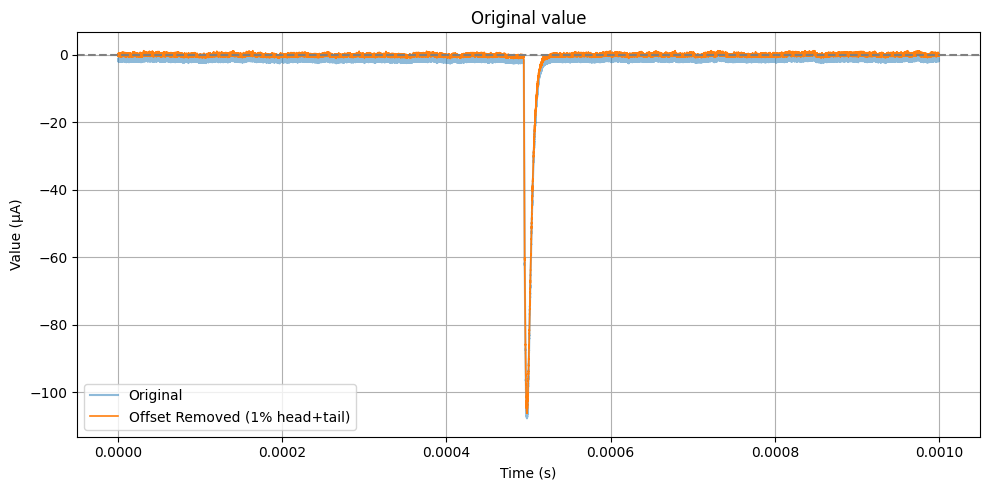

Mode: voltage
50 μA/V is considered. Unit: A


In [222]:
df = pd.read_csv(file_path, header=None, skiprows=30)

df.columns = ['Time', 'Value']
# 데이터 형식 변환...글자 -> NaN
df["Time"] = pd.to_numeric(df["Time"], errors='coerce')
df["Value"] = pd.to_numeric(df["Value"], errors='coerce')

# === 전류 시계열 추출 ===
current = df['Value'].values
n_total = len(current)
n_fraction = int(n_total * (fraction_percent / 100))

# === 앞쪽과 뒤쪽 데이터로 baseline 계산 === ###여기서도 잘 조절해봐.
front_section = current[:n_fraction]
back_section = current[-n_fraction:]
baseline_offset = np.mean(np.concatenate([front_section, back_section]))
#baseline_offset = np.mean(np.concatenate([ back_section]))
baseline_offset = 0.0 if np.isnan(baseline_offset) else baseline_offset
print(f"Offset: {baseline_offset:4f}")

# === offset 제거 ===
Cor_value = current - baseline_offset
df['Cor_value'] = Cor_value

if mode == 'voltage':
    print(f"V_max: {df.iloc[:, 1].max(skipna=True):.3f} V")
    print(f"V_min: {df.iloc[:, 1].min(skipna=True):.3f} V")
    print(f"V_pp: {df.iloc[:, 1].max(skipna=True)-df.iloc[:, 1].min(skipna=True):.3f} V")

    # === 결과 시각화 ===
    plt.figure(figsize=(10, 5))
    plt.plot(df['Time'], df['Value'], label='Original', alpha=0.5)
    plt.plot(df['Time'], df['Cor_value'], label=f'Offset Removed ({fraction_percent}% head+tail)', linewidth=1.2)
    plt.axhline(0, color='gray', linestyle='--')
    plt.xlabel("Time (s)")
    plt.ylabel("Value")
    plt.title("Original value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    df["Value"] = df["Cor_value"]
    print(f"Mode: voltage")
    
elif mode == 'current':
    df['Value'] = Current_scale*df['Value']
    df['Cor_value'] = Current_scale*df['Cor_value']
    print(f"I_max: {df.iloc[:, 1].max(skipna=True):.3f} μA")
    print(f"I_min: {df.iloc[:, 1].min(skipna=True):.3f} μA")
    print(f"I_pp: {df.iloc[:, 1].max(skipna=True)-df.iloc[:, 1].min(skipna=True):.3f} μA")

    # === 결과 시각화 ===
    plt.figure(figsize=(10, 5))
    plt.plot(df['Time'], df['Value'], label='Original', alpha=0.5)
    plt.plot(df['Time'], df['Cor_value'], label=f'Offset Removed ({fraction_percent}% head+tail)', linewidth=1.2)
    plt.axhline(0, color='gray', linestyle='--')
    plt.xlabel("Time (s)")
    plt.ylabel("Value (μA)")
    plt.title("Original value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    df["Value"] = df["Cor_value"]
    print(f"Mode: voltage")

    df["Value"] = df["Cor_value"]/1e6 #단위를 A로 변경
    print(f"{Current_scale} μA/V is considered. Unit: A")
else:
    print('error')

current mode is detected
 
Detected peaks at:
Time: 0.00050 s, Value: 0.000001 Watt


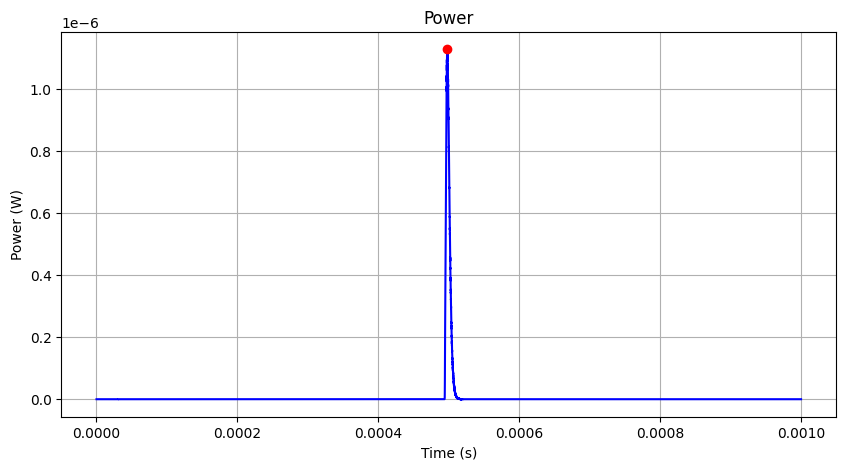

In [226]:
if 'Original_Value' not in df.columns:
    df['Original_Value'] = df['Value'].copy()

if mode == "voltage":
    #전압 기준
    df['Value'] = (df['Original_Value']**2)/R_load_voltage
    print("voltage mode is detected")
elif mode == "current":
    #전류 기준
    df['Value'] = (df['Original_Value']**2)*R_load_current
    print("current mode is detected")
    
else:
    print ("ERROR OCCURED. MODE SHOULD BE CHECKED.")

peaks, properties = find_peaks(df["Value"], height = 0.1*max(df['Value']), distance=10, prominence=0.1*max(df['Value']))  # Find peak & print time

print(" ")
print("Detected peaks at:")
for idx in peaks:
    print(f"Time: {df['Time'].iloc[idx]:.5f} s, Value: {df['Value'].iloc[idx]:.6f} Watt")

plt.figure(figsize=(10, 5))
plt.plot(df.iloc[:, 0], df.iloc[:, 1], label="AC current", color='b')
plt.plot(df["Time"].iloc[peaks], df["Value"].iloc[peaks], "ro", label='Detected Peaks')
plt.xlabel("Time (s)")
plt.ylabel("Power (W)")
plt.title("Power")
#plt.ylim(-60,60)
plt.grid(True)
plt.show()



Positive Energy: 0.000007 μJ
Negative Energy: 0.000000 μJ


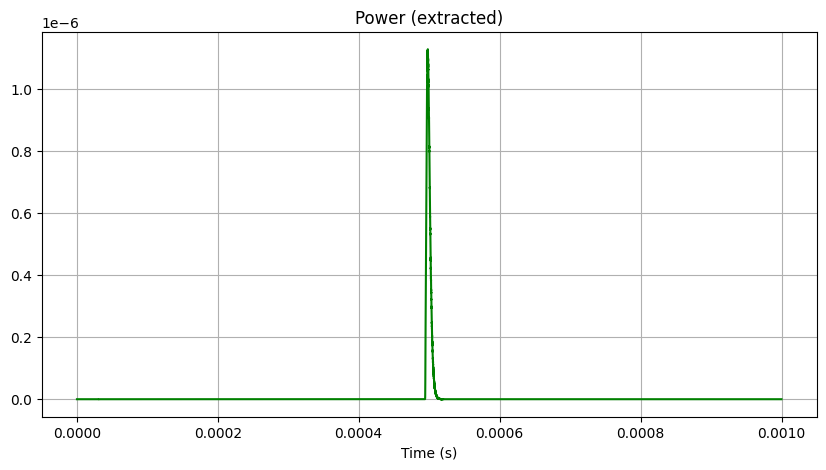

In [224]:
# 2. 특정 범위 선택
time_range = (df["Time"].min(), df["Time"].max())
#time_range = ( 0.03600 , 0.03900 ) ########################## MUST BE MODIFIED MANUALLY

df_filtered = df[(df.iloc[:, 0] >= time_range[0]) & (df.iloc[:, 0] <= time_range[1])]

# 양수/음수 분리
p_value = df_filtered[df_filtered["Value"] > 0]
n_value = df_filtered[df_filtered["Value"] < 0]
p_time = p_value["Time"].values
p_current = p_value["Value"].values
n_time = n_value["Time"].values
n_current = n_value["Value"].values

# 전하 적분 함수 정의 (1개 포인트도 대응), scale factor 고려 필요.
scale_factor = 1e6 ####################################################### 1e1: [J] / 1e3: [mJ} / 1e6: [μJ] / 1e9: [nJ]
def segment_and_integrate(current, time, df_full, threshold=0.01):
    if len(time) < 1:
        return 0.0
    total_charge = 0.0
    group_start = 0
    time_diffs = np.diff(time)
    for i, dt in enumerate(time_diffs):
        if dt > threshold:
            segment_t = time[group_start:i+1]
            segment_i = current[group_start:i+1]
            if len(segment_t) > 1:
                total_charge += scale_factor * cumulative_trapezoid(segment_i, segment_t, initial=0)[-1]
            elif len(segment_t) == 1:
                dt_est = 1e-6
                t0 = segment_t[0]
                if t0 in df_full["Time"].values:
                    idx = df_full.index[df_full["Time"] == t0].tolist()[0]
                    if 0 < idx < len(df_full) - 1:
                        dt_est = (df_full.iloc[idx + 1]["Time"] - df_full.iloc[idx - 1]["Time"]) / 2
                total_charge += scale_factor * segment_i[0] * dt_est
            group_start = i + 1
    if group_start < len(time):
        segment_t = time[group_start:]
        segment_i = current[group_start:]
        if len(segment_t) > 1:
            total_charge += scale_factor * cumulative_trapezoid(segment_i, segment_t, initial=0)[-1]
        elif len(segment_t) == 1:
            dt_est = 1e-6
            t0 = segment_t[0]
            if t0 in df_full["Time"].values:
                idx = df_full.index[df_full["Time"] == t0].tolist()[0]
                if 0 < idx < len(df_full) - 1:
                    dt_est = (df_full.iloc[idx + 1]["Time"] - df_full.iloc[idx - 1]["Time"]) / 2
            total_charge += scale_factor * segment_i[0] * dt_est
    return total_charge

# 적분 수행
p_charge = segment_and_integrate(p_current, p_time, df)
n_charge = segment_and_integrate(n_current, n_time, df)

print(f"Positive Energy: {p_charge:.6f} μJ")
print(f"Negative Energy: {n_charge:.6f} μJ")

plt.figure(figsize=(10, 5))
plt.plot(df_filtered.iloc[:, 0], df_filtered.iloc[:, 1], label="Value", color='g')
plt.xlabel("Time (s)")
#plt.ylabel("Value (μA)") ### 단위 고려 중요
plt.title("Power (extracted)")
#plt.ylim(-45, 5)
#plt.legend()
plt.grid(True)
plt.show()

Energy = 0.000007 μJ


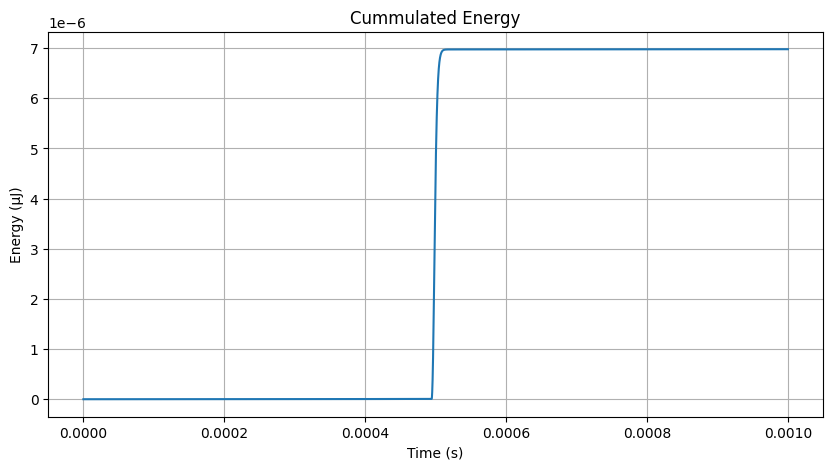

Filtered data saved at: G:\다른 컴퓨터\KHU PC\HI Lab\0. Projects\0. On going\2. Aloe inspired DEG\0. 실험자료\최최종피규어들\csv파일\Energy\Current\Aloe_8cm\Charge_tek0037ALL.csv


In [225]:
# ---- 아래 셀은 offset 바꿔가며 여러 번 실행해도 누적 안됨 ----
offset_value = 0.0########################## MUST BE MODIFIED MANUALLY

# 딱 한 번만 실행해서 '기준'을 저장
df_filtered_base = df_filtered.copy(deep=True)  # 원본 백업
current_adj = df_filtered_base["Value"] + offset_value

# 적분 (μA -> nC)
Energy = scale_factor * cumulative_trapezoid(current_adj.to_numpy(),
                                               df_filtered_base["Time"].to_numpy(),
                                               initial=0)

# 플롯
#print(f"{np.min(Energy):.3f} nC")
print(f"Energy = {np.max(Energy):.6f} μJ")
plt.figure(figsize=(10, 5))
#plt.ylim(-0.37,0.02)
plt.plot(df_filtered_base["Time"], Energy)
plt.xlabel("Time (s)") 
plt.ylabel("Energy (μJ)")
plt.title("Cummulated Energy")
plt.grid(True); plt.show()


# 8. 필터링된 데이터 저장
folder_path = os.path.dirname(file_path)
original_filename = os.path.basename(file_path)
filtered_file_name = f"Charge_{original_filename}"
filtered_file_path = os.path.join(folder_path, filtered_file_name)

#df_filtered.to_csv(filtered_file_path, index=False)
print(f"Filtered data saved at: {filtered_file_path}")
